
#1.0 - Tabela Utilizada no Drive

Estou utilizando a ultima tabela disponibilizada pela MEDICINA USP.<br>
Nome da Tabela: NEW-BDIPMama-INTELI(1).csv

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 - Buscando a tabela e importando as bibliotecas utilizadas

In [73]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix
import numpy as np
import imblearn as imb

Nomeei a tabela como tabela_completa

In [74]:
tabela_completa = pd.read_csv ('/content/drive/MyDrive/DRIVE - USPMedicina/NEW-BDIPMamaV11-INTELI (3).csv',delimiter=";")

In [75]:
tabela_completa['redcap_repeat_instrument'].value_counts()

dados_antropometricos          50137
dados_histopatologicos_mama     4626
registro_de_tumores             4525
Name: redcap_repeat_instrument, dtype: int64

# 2.0 - Observando os dados válidos
Para cada coluna da tabela, consultamos com o value_counts(), afim de consultar a quantidade de dados nas colunas, sendo assim, há a consulta para uma primeira seleção da tabela.<br><br>
Importante destacar que todas as colunas selecionadas até o momento tem mais de 1/3 dos registros válidos.
O restante foi ignorado devido à ausência de registros significativos.

# 3.0 - Premissas assumidas

Assumimos que todos os NaN acima do primeiro dado numérico significa que o dado não foi preenchido no cadastro do paciente, sendo assim, transformaremos este dado nulo em 0.0<br>
Para não perder todos os dados da amostra foi preferível substituir os nulos (Nan) pelo número 0.0 até chegar o primeiro exposto na coluna, este foi replicado na coluna abaixo até encontrar o próximo valor válido, segundo orientações docente para o entendimento dos dados. A partir deste momento, lê-se a tabela da seguinte forma:<br>

*   Caso observe uma coluna onde o primeiro dado é -1, significa que este é Nan.

*   Caso encontre uma coluna onde o primeiro dado é 0, este dado é lido como Não.

Optamos por renomear a tabela completa, que está no drive, para tabela tratada, a fim de conseguir fazer consultas na tabela completa ao longo do projeto, sem prejudicar a modelagem dos dados que ocorre simultaneamente.<br><br>

Utilizamos o comando fillna para buscar na coluna um valor válido e repetir nos dados vazios que iriam se repetir normalmente para o mesmo record_id. Posteriormente,a fim de transformar as string dessa coluna em novas colunas com dados numéricos, especificamente, dados de afirmação (Sim) ou negação (Não), utilizamos o método dummies.

Sendo assim, lê-se a tabela da seguinte forma:

*   Caso observe uma coluna onde o primeiro dado é -1, significa que este é **Nan**;
*   Caso observe uma coluna onde o primeiro dado é 0, significa que este é lido como **Não**;
*   Caso Observe uma coluna onde o primeiro dado é 1, significa que este é lido como **Sim**;

Fizemos este comando para a coluna "redcap_repeat_instrument" visando replicar a coluna em três dados diferentes, pegando seus respectivos valores e transformando em colunas.

In [76]:
tabela_trat = tabela_completa.fillna(method='ffill').dropna(subset=['redcap_repeat_instrument']) #Utilizei o fillna com o método ffill para buscar o último valor válido e repetir na linha posterior.
tabela_trat['redcap_repeat_instrument'].unique()

tabela_tratada = pd.get_dummies(tabela_trat, columns=['redcap_repeat_instrument', 'antec_fam_cancer_mama', 'ultinfo']) #Utilizei o método get_dummies na coluna redcap_repeat_instrument para separar o conteúdo dela em novas colunas no final

A saída esperada é a exclusão da coluna "redcap_repeat_instrument", e a criação de três novas colunas, respectivamente:
* "redcap_repeat_instrument_dados_antropometricos";
* "redcap_repeat_instrument_dados_histopatologicos_mama"; e 
* "redcap_repeat_instrument_registro_de_tumores".

Sendo assim, indicando 1 e 0 nos registros do paciente.<br>

Fiz o mesmo processo para a coluna "antec_fam_cancer_mama" que indica se há algum familiar com câncer ou não, buscando transformar as string "Sim" e "Não" em 0 e 1.

Selecionamos as colunas que iremos utilizar, como retiramos as duplicatas com base 

In [77]:
ta_final = tabela_tratada[['record_id','t','n','m', 'ultinfo_1.0',	'ultinfo_2.0',	'ultinfo_3.0',	'ultinfo_4.0','breast_feeding_time', 'dob','tumor_subtype',
                           'antec_fam_cancer_mama_Não','antec_fam_cancer_mama_Sim', 'tempo_rep_hormo','bmi', 'follow_up_days', 'menarche', 'tobaco','alcohol',
                           'date_last_fu','familial_degree___1','familial_degree___2','familial_degree___3', 'primary_diganosis','benign']]
tabela_final = ta_final.fillna(-1)
tabela_final = tabela_final.drop_duplicates(subset='record_id', keep='last', ignore_index=True)

# 4.0 - Transformando Colunas
Foi necessário transformar a coluna data de nascimento (dob) em idade, visto que será mais fácil saber a idade da paciente quando gerarmos o modelo de predição.<br><br>
A data de nascimento foi calculada até a última consulta do mesmo, e não até a data presente. Preferimos demonstrar desta forma devido a não existência da data de óbito no banco de dados, e também, por nos concentrarmos em encontrar a relação da sobrevida do paciente até a ultima consulta.
<br><br>
Abaixo o código que gera a idade a partir da data de nascimento.

In [78]:
from datetime import datetime, date
tabela_final['dob']
def pegar_idade(nascimento, _date):
  nascimento = datetime.strptime(nascimento,"%d/%m/%Y").date()
  _date = datetime.strptime(_date,"%d/%m/%Y").date()
  idade = _date.year - nascimento.year
  if(nascimento.month == _date.month and nascimento.day >= _date.year):
    idade = idade + 1
  elif(nascimento.month > _date.month):
    idade = idade + 1
  return idade

def convertDate(age):
  return datetime.strptime(age,"%d/%m/%Y").date()
tabela_final['dob'].apply(convertDate)
tabela_final['date_last_fu'].apply(convertDate)
tabela_final['idade'] = ""
for ind in tabela_final.index:
    tabela_final['idade'][ind] = pegar_idade(tabela_final['dob'][ind], tabela_final['date_last_fu'][ind])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Com o intuito de realizar testes por meio de modelos de classificação, foi necessário transformar a coluna dos dias de sobrevida em um filtro, sendo adotado para essa aplicação uma rotulação de 1 a 4 com base em quartis de modo que os dados pudessem ser melhor enquadrados dentro da aplicação do modelo e evitasse ruídos nos resultados. A seguir, segue o código da função responsável por essa conversão:

In [80]:
days_since_the_last_tumor = tabela_final.follow_up_days.values
tabela_final['class_sobrevida'] = np.nan

lower_day = min(days_since_the_last_tumor)
max_day = max(days_since_the_last_tumor)


quartile = (max_day - lower_day)/4
first_quartile = lower_day + quartile
second_quartile = lower_day + (2*quartile)
third_quartile = lower_day + (3*quartile)

i = 0

for day in days_since_the_last_tumor:
  if day == 0:
    tabela_final.loc[i, 'class_sobrevida'] = -1
  if day <= first_quartile:
    tabela_final.loc[i, 'class_sobrevida'] = 1
  elif day <= second_quartile:
    tabela_final.loc[i, 'class_sobrevida'] = 2
  elif day <= third_quartile:
    tabela_final.loc[i, 'class_sobrevida'] = 3
  elif day > third_quartile:
    tabela_final.loc[i, 'class_sobrevida'] = 4
  else:
    tabela_final.loc[i, 'class_sobrevida'] = -1
  
  i += 1

Após essas alterações e a finalização da manipulação das colunas que recebem dados em formatos de data (dd/mm/aaaa), foi necessário eliminar essas colunas para que essa formatação de dados não interferisse como um ruído no treinamento e aprendizado do modelo.

In [83]:
df_filtered.pop('dob')
df_filtered.pop('date_last_fu')

0       01/01/2021
1       26/04/2014
2       17/11/2016
3       02/05/2019
4       24/05/2017
           ...    
4129    03/04/2021
4130    22/06/2021
4131    11/08/2021
4132    10/10/2021
4133    13/05/2021
Name: date_last_fu, Length: 4134, dtype: object

A seguir foi realizada apenas uma visualização da variável de saída do modelo para compreender como os dados estavam distribuídos dentro dessa coluna.

In [85]:
df_filtered['class_sobrevida'].value_counts()

2.0    1935
1.0    1432
3.0     623
4.0     144
Name: class_sobrevida, dtype: int64

Com a finalidade de facilitar a visualização e compreensão das colunas utilizadas no modelo, foi necessário renomear algumas Features, que podem ser visualizadas no código abaixo:

In [86]:
df_filtered.rename({'ultinfo_1.0':'ultinfo_1','ultinfo_2.0':'ultinfo_2',
                     'ultinfo_3.0':'ultinfo_3', 'ultinfo_4.0':'ultinfo_4',
                     'record_id':'pacientes', 't':'tumor', 'n':'nodulo',
                     'm':'metastese', 'breast_feeding_time':'tempo_de_amamentacao',
                     'dob':'data_de_nascimento', 'tobaco':'fumante', 'alcohol':'alcolatra',
                     'date_last_fu':'data_ultima_consulta', 'familial_degree___1':'grau_parentesco_1',
                     'familial_degree___2':'grau_parentesco_2', 'familial_degree___3':'grau_parentesco_3',
                     'primary_diganosis':'tipo_tumor', 'tumor_subtype':'subtipo_tumoral',
                     'menarche':'primeira_menstruacao', 'bmi':'IMC', 
                     'benign':'benigno/maligno'}, axis='columns', inplace=True)

Foi utilizado o método query para pegar apenas a ultima informação dos pacientes que já foram a óbito por Câncer, para que seja possível conferir com o mínimo de viés possível os dados, pois partimos do suposto que os dados dos que morreram com Câncer .

In [87]:
x_inter3 = df_filtered.query('ultinfo_3==1')
x_inter3

,pacientes,tumor,nodulo,metastese,ultinfo_1,ultinfo_2,ultinfo_3,ultinfo_4,tempo_de_amamentacao,subtipo_tumoral,...,primeira_menstruacao,fumante,alcolatra,grau_parentesco_1,grau_parentesco_2,grau_parentesco_3,tipo_tumor,benigno/maligno,idade,class_sobrevida
5,1705,1.0,1.0,0.0,0,0,1,0,-1.0,4.0,...,-1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,51,2.0
8,1898,4.0,2.0,1.0,0,0,1,0,-1.0,3.0,...,-1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,63,1.0
12,2016,3.0,3.0,0.0,0,0,1,0,-1.0,3.0,...,-1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,45,2.0
19,2350,3.0,2.0,0.0,0,0,1,0,-1.0,3.0,...,-1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,74,1.0
20,2370,2.0,1.0,0.0,0,0,1,0,-1.0,3.0,...,-1.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,51,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4054,79944,42.0,1.0,0.0,0,0,1,0,12.0,4.0,...,9.0,3.0,3.0,1.0,1.0,0.0,2.0,2.0,37,1.0
4069,80274,3.0,1.0,0.0,0,0,1,0,24.0,4.0,...,12.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,34,1.0
4080,80930,3.0,1.0,0.0,0,0,1,0,60.0,4.0,...,13.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,62,1.0
4111,81873,42.0,1.0,1.0,0,0,1,0,6.0,4.0,...,13.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,62,1.0


#5.0 - Testando o Modelo Preditivo#

Para testar os modelos de predição, foi necessário saber qual melhor se encaixava com nossos dados e nosso problema. Sendo assim, preferimos nesse momento verificar a acurácia de alguns modelos mais utilizados e ver como os dados se comportam com o treinamento e teste.<br><br>
Na célula de código abaixo, é possível visualizar a definição das variáveis de entrada e saída do modelo preditivo, bem como a porcentagem desses dados que foram selecionados para treino e para teste.

In [88]:
#separando os dados:
x_entrada = x_inter3[['tumor','nodulo','metastese', 'tempo_de_amamentacao',
                         'fumante', 'alcolatra','primeira_menstruacao',
                       'grau_parentesco_1','grau_parentesco_2', 'grau_parentesco_3',
                       'tipo_tumor', 'idade']].values
                       
y_saida = x_inter3['class_sobrevida'].values

X_train, X_test, Y_train, Y_test = train_test_split(x_entrada, y_saida, 
                                                    test_size = 0.3, 
                                                    random_state = 42)


##**5.1 - Árvore de decisão**

Utilizamos a árvore decisão pois gostaríamos de saber o resultados das séries escolhidas.

Uma árvore de decisão é um mapa dos possíveis resultados de uma série de escolhas relacionadas. Ela permite prever categorias discretas com base na comparção de elementos pré-selecionados nesse modelo( no caso as features de teste) e retorna uma classificação para essa predição. 

### 5.1.1 - Arvore de decisão sem hiper-parâmetros

Em um primeiro momento, foi decidido testar o modelo classificatório sem o uso de hiper-parâmetros, visando observar como os nossos dados tratados interferem no módelo sem qualquer influência de manipulação.

In [89]:
# # Treinando o modelo
model_tree = DecisionTreeClassifier(criterion='entropy', random_state = 42)

model_tree.fit(X_train,Y_train)

# Fazendo as predições
Y_pred_tree = model_tree.predict(X_test)


Arvore de decisão


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


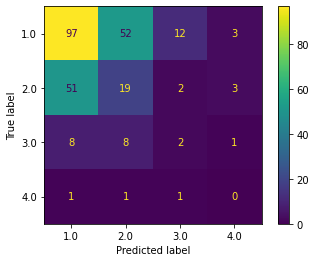

Acc treino:  0.9950738916256158
Acc teste:  0.4521072796934866
Revocação: [0.59146341 0.25333333 0.10526316 0.        ]
Precisão: [0.61783439 0.2375     0.11764706 0.        ]
F1_score: [0.61783439 0.2375     0.11764706 0.        ]


In [90]:
print('Arvore de decisão')
plot_confusion_matrix(model_tree, X_test, Y_test)  
plt.show()

print('Acc treino: ', model_tree.score(X_train, Y_train ))
print('Acc teste: ', model_tree.score(X_test, Y_test.squeeze() ))
print('Revocação:',recall_score(Y_test,Y_pred_tree,average=None))
print('Precisão:',precision_score(Y_test,Y_pred_tree,average=None))
print('F1_score:',precision_score(Y_test,Y_pred_tree,average=None))
# print('Roc:',roc_auc_score(Y_test, Y_pred_tree,multi_class='ovo'))


In [91]:
print(classification_report(Y_test, Y_pred_tree))

              precision    recall  f1-score   support

         1.0       0.62      0.59      0.60       164
         2.0       0.24      0.25      0.25        75
         3.0       0.12      0.11      0.11        19
         4.0       0.00      0.00      0.00         3

    accuracy                           0.45       261
   macro avg       0.24      0.24      0.24       261
weighted avg       0.47      0.45      0.46       261



Como pôde ser percebido,o modelo sem o uso de qualquer hiper parâmetro possui uma acurácia de teste de 45% , indicando uma forte taxa de erro do modelo em cima de predições falso negativas e positivas, visto que a quantidade de desses tipos de erros é inversamente proporcional à pontuação da acurácia.

 ### 5.1.2-Arvore de decisão com hiper-parâmetro (Grid Search)

Visando buscar melhores resultados para a Árvore de Decisão, foi utilizado a ferramenta de busca de hiper-parâmetros Grid Search, que realiza vários testes com base nos hiper-perâmetros pré selecionados e retorna o melhor resultado dentre todas essa repetiçoes do modelo.

In [92]:
from sklearn.model_selection import GridSearchCV
# Cria o GridSearchCV

parameters_tree = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter':['best', 'random”'],
    'max_depth':range(2,16,2)
}
grid_tree= GridSearchCV(DecisionTreeClassifier(), parameters_tree)
# Treina os modelos e guarda na variável modelGS o melhor modelo
grid_tree.fit(X_train, Y_train)

modelGS_tree = grid_tree.best_estimator_

y_pred_tree = modelGS_tree.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred_tree)

print('Decision Tree score: {}'.format(accuracy))
grid_tree.best_params_


Decision Tree score: 0.4521072796934866


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 381, in fit
    splitter = SPLITTERS[self.splitter](
KeyError: 'random”'

-----------------------------------------

{'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}

In [93]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)

0.6305649640970058
{'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}


In [94]:
print('Acc treino:',modelGS_tree.score(X_train,Y_train))
print('Acc teste:',accuracy_score(Y_test,y_pred_tree.squeeze()))
print('Revocação:',recall_score(Y_test,y_pred_tree,average=None))
print('Precisão:',precision_score(Y_test,y_pred_tree,average=None))
print('F1_score:',f1_score(Y_test,y_pred_tree,average=None))

Acc treino: 0.6403940886699507
Acc teste: 0.6283524904214559
Revocação: [1. 0. 0. 0.]
Precisão: [0.62835249 0.         0.         0.        ]
F1_score: [0.77176471 0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


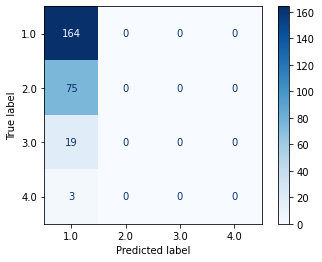

In [95]:
plot_confusion_matrix(modelGS_tree, X_test, Y_test, cmap='Blues', values_format='.0f');

Como pôde ser visualizado, utilizando dos melhores hiper-parâmetros para o modelo segundo o Grid Search, a acurácia teve um aumento de 17% em relação ao modelo anterior e, visto o aumento da pontuação do recall, que é fortemente influenciado pela quantidade de falsos negativos, acredita-se que esse tipo de dado tenha diminuído de um modelo para  outro.

###5.1.3 -Arvore de decisão com hiper-parâmetro( Randomized Search)

Buscando ainda analisar outros modelos de busca de hiper-parâmetros para servir de comparação com os resultados obtidos, foi o utilizado também o Randomized Search para a busca dos melhores hiper-parâmetros.

In [96]:
parametros_tree = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter':['best', 'random”'],
    'max_depth':range(2,16,2)
}
randomized_search_tree = RandomizedSearchCV(estimator = DecisionTreeClassifier(),param_distributions=parametros_tree)
randomized_search_tree.fit(X_train,Y_train.squeeze())

modelRS_tree= randomized_search_tree.best_estimator_

y_predRS_tree = modelRS_tree.predict(X_test)

accuracy = accuracy_score(Y_test, y_predRS_tree)

print('SVM score: {}'.format(accuracy))
randomized_search_tree.best_params_

SVM score: 0.6283524904214559


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

-------------------------------------

{'splitter': 'best', 'max_depth': 2, 'criterion': 'entropy'}

In [97]:
print(randomized_search_tree.best_score_)
print(randomized_search_tree.best_params_)

0.6223682427855304
{'splitter': 'best', 'max_depth': 2, 'criterion': 'entropy'}


In [98]:
print('Acc treino:',modelRS_tree.score(X_train,Y_train))
print('Acc teste:',modelRS_tree.score(X_test,y_predRS_tree.squeeze()))
print('Revocação:',recall_score(Y_test,y_predRS_tree,average=None))
print('Precisão:',precision_score(Y_test,y_predRS_tree,average=None))
print('F1_score:',precision_score(Y_test,y_predRS_tree,average=None))

Acc treino: 0.6403940886699507
Acc teste: 1.0
Revocação: [1. 0. 0. 0.]
Precisão: [0.62835249 0.         0.         0.        ]
F1_score: [0.62835249 0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


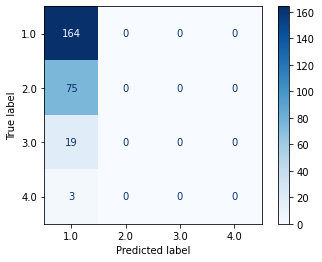

In [99]:
plot_confusion_matrix(modelRS_tree, X_test, Y_test, cmap='Blues', values_format='.0f');

Como pôde ser visualizado, utilizando os melhores hiper-parâmetros segundo o Randomized Search, o modelo teve um aumento de acurácia surpreendente para 100% , mas que não foi acompanhado com um aumento das outras métricas, indicando a presença de uma forte feature agindo como um elemento viciante para o modelo.

## **5.2 - KNN**

Buscamos utilizar o KNN para observar as amostras vizinhas e encontrar, com base nas comparações, novas predições. 

A ideia principal do KNN é determinar o rótulo de classificação de uma amostra baseado nas amostras vizinhas advindas de um conjunto de treinamento. Dessa forma, é possível predizer um resultado com base na comparação dos dados mais próximos e retorná-lo em forma de uma classificação. 

### 5.2.1 - KNN sem hiper-parâmetros

Em um primeiro momento, foi decidido testar o modelo classificatório sem o uso de hiper-parâmetros, visando observar como os nossos dados tratados interferem no módelo sem qualquer influência de manipulação.

In [100]:
#testando o modelo
model_knn= KNeighborsClassifier(n_neighbors=23)
model_knn.fit(X_train, Y_train)

Y_pred_knn = model_knn.predict(X_test)



KNN


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


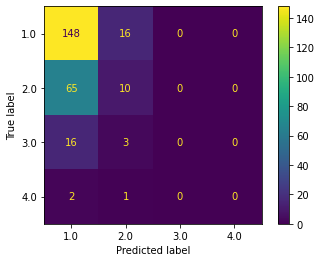

Acc treino:  0.6535303776683087
Acc teste:  0.6053639846743295
Revocação: [0.90243902 0.13333333 0.         0.        ]
Precisão: [0.64069264 0.33333333 0.         0.        ]
F1_score: [0.64069264 0.33333333 0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
print('KNN')
plot_confusion_matrix(model_knn, X_test, Y_test)  
plt.show()

print('Acc treino: ', model_knn.score(X_train, Y_train ))
print('Acc teste: ', model_knn.score(X_test, Y_test.squeeze() ))
print('Revocação:',recall_score(Y_test,Y_pred_knn,average=None))
print('Precisão:',precision_score(Y_test,Y_pred_knn,average=None))
print('F1_score:',precision_score(Y_test,Y_pred_knn,average=None))

In [102]:
print(classification_report(Y_test, Y_pred_knn))

              precision    recall  f1-score   support

         1.0       0.64      0.90      0.75       164
         2.0       0.33      0.13      0.19        75
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00         3

    accuracy                           0.61       261
   macro avg       0.24      0.26      0.23       261
weighted avg       0.50      0.61      0.53       261



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Como pôde ser percebido, o modelo sem o uso de qualquer hiper-parâmetro possui uma acurácia de teste de 60% , indicando uma forte taxa de erro do modelo em cima de predições falso negativas e positivas, visto que a quantidade de desses tipos de erros é inversamente proporcional à pontuação da acurácia.Entretanto, ainda que possuam uma considerável taxa de erro, ainda mostra um desempenho melhor que o modelo anterior para esse mesmo tipo de teste.

### 5.2.2 KNN com hiper-parâmetros(Grid Search)

Visando buscar melhores resultados para o KNN, foi utilizado a ferramenta de busca de hiper-parâmetros Grid Search, que realiza vários testes com base nos hiper-perâmetros pré selecionados e retorna o melhor resultado dentre todas essa repetiçoes do modelo.

In [103]:
from sklearn.model_selection import GridSearchCV
# Cria o GridSearchCV

parameters_knn = {'n_neighbors':range(5,110,5), 
              'weights':['uniform'],
              'algorithm':['auto'],
              'leaf_size':range(1,50)
              }
grid_knn = GridSearchCV(KNeighborsClassifier(), parameters_knn)
# Treina os modelos e guarda na variável modelGS o melhor modelo
grid_knn.fit(X_train, Y_train)

modelGS_knn= grid_knn.best_estimator_

y_pred_knn = modelGS_knn.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred_knn)

print('KNN score: {}'.format(accuracy))
grid_knn.best_params_


KNN score: 0.6130268199233716


{'algorithm': 'auto', 'leaf_size': 31, 'n_neighbors': 50, 'weights': 'uniform'}

In [104]:
print(grid_knn.best_score_)
print(grid_knn.best_params_)

0.6469719550196451
{'algorithm': 'auto', 'leaf_size': 31, 'n_neighbors': 50, 'weights': 'uniform'}


In [105]:
print('Acc treino:',modelGS_knn.score(X_train,Y_train))
print('Acc teste:',accuracy_score(Y_test,y_pred_knn.squeeze()))
print('Revocação:',recall_score(Y_test,y_pred_knn,average=None))
print('Precisão:',precision_score(Y_test,y_pred_knn,average=None))
print('F1_score:',f1_score(Y_test,y_pred_knn,average=None))

Acc treino: 0.645320197044335
Acc teste: 0.6130268199233716
Revocação: [0.95121951 0.05333333 0.         0.        ]
Precisão: [0.63157895 0.28571429 0.         0.        ]
F1_score: [0.75912409 0.08988764 0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


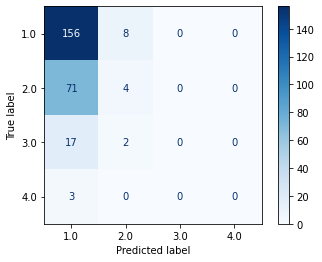

In [106]:
plot_confusion_matrix(modelGS_knn, X_test, Y_test, cmap='Blues', values_format='.0f');

Como pôde ser visualizado, utilizando dos melhores hiper-parâmetros para o modelo segundo o Grid Search, a acurácia teve um aumento de apenas 1% em relação ao knn anterior e, visto o aumento pouco significativodas outras métricas, acredita-se que o resultado aponte para um problema no processo de feature engineering que no pôde ser corrigido somente por meio de hiper-parâmetros

###5.2.3- KNN com hiper-parâmetros(Randomized Search)

Buscando ainda analisar outros modelos de busca de hiper-parâmetros para servir de comparação com os resultados obtidos, foi o utilizado também o Randomized Search para a busca dos melhores hiper-parâmetros.

In [107]:
parametros_knn={
    'n_neighbors':range(5,110,5),
    'weights':['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':range(1,50),
}
randomized_search_knn = RandomizedSearchCV(estimator = KNeighborsClassifier(),param_distributions=parametros_knn)
randomized_search_knn.fit(X_train,Y_train.squeeze())

modelRS_knn = randomized_search_knn.best_estimator_

y_predRS_knn = modelRS_knn.predict(X_test)

accuracy = accuracy_score(Y_test, y_predRS_knn)

print('KNN score: {}'.format(accuracy))
randomized_search_knn.best_params_

KNN score: 0.6130268199233716


{'weights': 'uniform',
 'n_neighbors': 45,
 'leaf_size': 27,
 'algorithm': 'kd_tree'}

In [108]:
print(randomized_search_knn.best_score_)
print(randomized_search_knn.best_params_)

0.6436526215959897
{'weights': 'uniform', 'n_neighbors': 45, 'leaf_size': 27, 'algorithm': 'kd_tree'}


In [109]:
knn_best= randomized_search_knn.best_estimator_
knn_best
print('Acc treino:',knn_best.score(X_train,Y_train))
print('Acc teste:',knn_best.score(X_test,Y_test.squeeze()))
print('Revocação:',recall_score(Y_test,y_predRS_knn,average=None))
print('Precisão:',precision_score(Y_test,y_predRS_knn,average=None))
print('F1_score:',precision_score(Y_test,y_predRS_knn,average=None))

Acc treino: 0.6486042692939245
Acc teste: 0.6130268199233716
Revocação: [0.95121951 0.05333333 0.         0.        ]
Precisão: [0.63673469 0.25       0.         0.        ]
F1_score: [0.63673469 0.25       0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


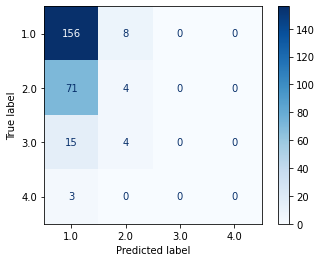

In [110]:
plot_confusion_matrix(modelRS_knn, X_test, Y_test, cmap='Blues', values_format='.0f');

Como pôde ser visualizado, utilizando os melhores hiper-parâmetros segundo o Randomized Search, o modelo teve o mesmo aumento de acurácia de 1% em comparação ao modelo original, além das demais métricas permanecerem sem variações significativas, reforçando o hipótese do problema de manipulação dos dados.

##**5.3 - Random Forest**

A ideia principal do Random Forest é fazer o agrupamento de uma série de árvores de decisão criadas durante o processo de treinamento do modelo gerar predições (nesse caso classificatórias) com base nas comparações conjunta entre as estruturas arbóreas desenvolvidas<br><br>
Esse modelo foi utilizado como mais uma métrica de comparação entre qual modelo classificatório seria o mais adequado para o problema em análise.

###5.3.1- Random Forest sem hiper-parâmetros

Em um primeiro momento, foi decidido testar o modelo classificatório sem o uso de hiper-parâmetros, visando observar como os nossos dados tratados interferem no módelo sem qualquer influência de manipulação.

In [111]:
#testando o modelo
model_rf= RandomForestClassifier(random_state=3,n_estimators=100, max_depth = 30, criterion = 'gini')
model_rf.fit( X_train, Y_train)

Y_pred_rf = model_rf.predict(X_test)

Random Forest


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


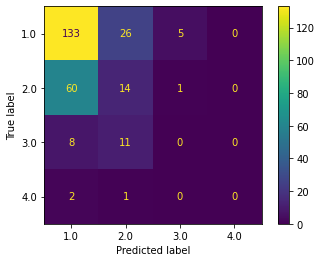

Acc treino:  0.9950738916256158
Acc teste:  0.5632183908045977
Revocação: [0.81097561 0.18666667 0.         0.        ]
Precisão: [0.65517241 0.26923077 0.         0.        ]
F1_score: [0.65517241 0.26923077 0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
print('Random Forest')
plot_confusion_matrix(model_rf, X_test, Y_test)  
plt.show()

print('Acc treino: ', model_rf.score(X_train, Y_train ))
print('Acc teste: ', model_rf.score(X_test, Y_test.squeeze() ))
print('Revocação:',recall_score(Y_test,Y_pred_rf,average=None))
print('Precisão:',precision_score(Y_test,Y_pred_rf,average=None))
print('F1_score:',precision_score(Y_test,Y_pred_rf,average=None))

In [113]:
print(classification_report(Y_test, Y_pred_knn))

              precision    recall  f1-score   support

         1.0       0.64      0.90      0.75       164
         2.0       0.33      0.13      0.19        75
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00         3

    accuracy                           0.61       261
   macro avg       0.24      0.26      0.23       261
weighted avg       0.50      0.61      0.53       261



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Como pôde ser percebido, o modelo sem o uso de qualquer hiper-parâmetro possui uma acurácia de teste de 56% , indicando uma forte taxa de erro do modelo em cima de predições falso negativas e positivas, visto que a quantidade de desses tipos de erros é inversamente proporcional à pontuação da acurácia.Entretanto, a baixa acurácia( fortememnte influenciada pelos falsos positivos) e alta revocação(fortemente influenciada pelos falsos negativos) indica que o modelo erra mais os falsos positivos que os falsos negativos

###5.3.2 - Random Forest com hiper-parâmetros(Grid Search)

Visando buscar melhores resultados para o Random Forest, foi utilizado a ferramenta de busca de hiper-parâmetros Grid Search, que realiza vários testes com base nos hiper-perâmetros pré selecionados e retorna o melhor resultado dentre todas essa repetiçoes do modelo.

In [114]:
from sklearn.model_selection import GridSearchCV
# Cria o GridSearchCV

parameters_rf = {'n_estimators':range(50,250, 50), 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':range(2,8,2),
              }
grid_rf = GridSearchCV(RandomForestClassifier(), parameters_rf)
# Treina os modelos e guarda na variável modelGS o melhor modelo
grid_rf.fit(X_train, Y_train)

modelGS_rf = grid_rf.best_estimator_

y_pred_rf = modelGS_rf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred_rf)

print('Random Forest score: {}'.format(accuracy))
grid_rf.best_params_


Random Forest score: 0.5632183908045977


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

{'criterion': 'gini', 'min_samples_split': 6, 'n_estimators': 50}

In [115]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.6453461590570384
{'criterion': 'gini', 'min_samples_split': 6, 'n_estimators': 50}


In [116]:
print('Acc treino:',modelGS_rf.score(X_train,Y_train))
print('Acc teste:',modelGS_rf.score(X_test,y_pred_rf))
print('Revocação:',recall_score(Y_test,y_pred_rf,average=None))
print('Precisão:',precision_score(Y_test,y_pred_rf,average=None))
print('F1_score:',precision_score(Y_test,y_pred_rf,average=None))

Acc treino: 0.8784893267651889
Acc teste: 1.0
Revocação: [0.82317073 0.16       0.         0.        ]
Precisão: [0.64593301 0.24       0.         0.        ]
F1_score: [0.64593301 0.24       0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


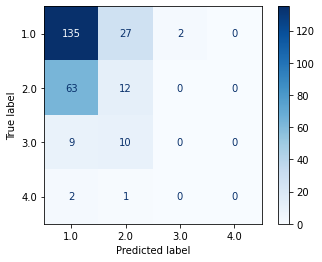

In [117]:
plot_confusion_matrix(modelGS_rf, X_test, Y_test, cmap='Blues', values_format='.0f');

Como pôde ser visualizado, utilizando dos melhores hiper-parâmetros para o modelo segundo o Grid Search, a acurácia teve um surpreendente aumento para 100% de acurácia de teste mas que não foi acompanhado por um aumento das outras métricas, indicando que essa surpreendente pontuação possui grandes chances de estar ligada à um vício do modelo em relação à alguns dados

###5.3.3- Random Forest com hiper-parâmetros(Randomized Search)

Buscando ainda analisar outros modelos de busca de hiper-parâmetros para servir de comparação com os resultados obtidos, foi o utilizado também o Randomized Search para a busca dos melhores hiper-parâmetros.

In [118]:
parametros_rf={
    'n_estimators':range(1,350),
    'criterion':['gini','entropy','log_loss'],
    'min_samples_split':range(1,10),
}
randomized_search_rf=RandomizedSearchCV(estimator = RandomForestClassifier(),param_distributions=parametros_rf)
randomized_search_rf.fit(X_train,Y_train.squeeze())

modelRS_rf = randomized_search_rf.best_estimator_

y_predRS_rf = modelRS_rf.predict(X_test)

accuracy = accuracy_score(Y_test, y_predRS_rf)

print('Random Forest score: {}'.format(accuracy))
randomized_search_rf.best_params_


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

Random Forest score: 0.5632183908045977


{'n_estimators': 176, 'min_samples_split': 5, 'criterion': 'entropy'}

In [119]:
print(randomized_search_rf.best_score_)
print(randomized_search_rf.best_params_)

0.6371765343449397
{'n_estimators': 176, 'min_samples_split': 5, 'criterion': 'entropy'}


In [120]:
print('Acc treino:',modelRS_rf.score(X_train,Y_train))
print('Acc teste:',modelRS_rf.score(X_test,y_predRS_rf.squeeze()))
print('Revocação:',recall_score(Y_test,y_predRS_rf,average=None))
print('Precisão:',precision_score(Y_test,y_predRS_rf,average=None))
print('F1_score:',precision_score(Y_test,y_predRS_rf,average=None))

Acc treino: 0.9310344827586207
Acc teste: 1.0
Revocação: [0.82926829 0.14666667 0.         0.        ]
Precisão: [0.64761905 0.23404255 0.         0.        ]
F1_score: [0.64761905 0.23404255 0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


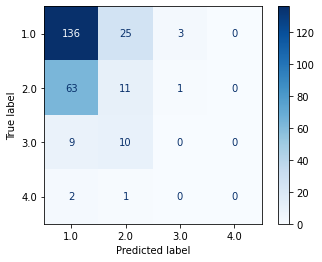

In [121]:
plot_confusion_matrix(modelRS_rf, X_test, Y_test, cmap='Blues', values_format='.0f');

Como pôde ser visualizado, utilizando os melhores hiper-parâmetros segundo o Randomized Search, o modelo teve o mesmo aumento de acurácia para 100% sem a alteração das demais métricas, reforçando a teoria do vício do modelo durante o processo de treino.

##**5.4 - SVM**

O SVM é um algoritmo que busca uma linha de separação entre duas classes distintas, analisando os dois pontos, um de cada grupo, mais próximos da outra classe. Isto é, o SVM escolhe a reta entre dois grupos que se distancia mais de cada um e, após descoberta essa reta, o programa conseguirá predizer a qual classe pertence um novo dado ao checar de qual lado da reta ele está.<br><br>
Esse modelo foi utilizado como mais uma métrica de comparação entre qual modelo classificatório seria o mais adequado para o problema em análise.


###5.4.1- SVM sem hiper-parâmetros

Em um primeiro momento, foi decidido testar o modelo classificatório sem o uso de hiper-parâmetros, visando observar como os nossos dados tratados interferem no módelo sem qualquer influência de manipulação.

In [122]:
#testando o modelo
model_svm= SVC(random_state=3)
model_svm.fit( X_train, Y_train)

Y_pred_svm = model_svm.predict(X_test)

SVM


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


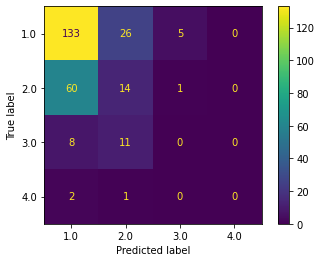

Acc treino:  0.6403940886699507
Acc teste:  0.6283524904214559
Revocação: [1. 0. 0. 0.]
Precisão: [0.62835249 0.         0.         0.        ]
F1_score: [0.62835249 0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
print('SVM')
plot_confusion_matrix(model_rf, X_test, Y_test)  
plt.show()

print('Acc treino: ', model_svm.score(X_train, Y_train ))
print('Acc teste: ', model_svm.score(X_test, Y_test.squeeze() ))
print('Revocação:',recall_score(Y_test,Y_pred_svm,average=None))
print('Precisão:',precision_score(Y_test,Y_pred_svm,average=None))
print('F1_score:',precision_score(Y_test,Y_pred_svm,average=None))

In [124]:
print(classification_report(Y_test, Y_pred_svm))

              precision    recall  f1-score   support

         1.0       0.63      1.00      0.77       164
         2.0       0.00      0.00      0.00        75
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00         3

    accuracy                           0.63       261
   macro avg       0.16      0.25      0.19       261
weighted avg       0.39      0.63      0.48       261



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Como pôde ser percebido, o modelo sem o uso de qualquer hiper-parâmetro possui uma acurácia de teste de 62% , indicando uma forte taxa de erro do modelo em cima de predições falso negativas e positivas, visto que a quantidade de desses tipos de erros é inversamente proporcional à pontuação da acurácia.Entretanto, a baixa acurácia( fortememnte influenciada pelos falsos positivos) e alta revocação(fortemente influenciada pelos falsos negativos) indica que o modelo erra mais os falsos positivos que os falsos negativos, ainda que o valor exorbitantemente alto da revocação (100%) sinalize para um vício do modelo durante o treinamento.

###5.4.2 - SVM com hiper-parâmetros(Grid Search)

Visando buscar melhores resultados para o SVM, foi utilizado a ferramenta de busca de hiper-parâmetros Grid Search, que realiza vários testes com base nos hiper-perâmetros pré selecionados e retorna o melhor resultado dentre todas essa repetiçoes do modelo.

In [125]:
from sklearn.model_selection import GridSearchCV
# Cria o GridSearchCV

parameters_svm = {
              'kernel':['rbf'],#['linear','poly','rbf','sigmoid','precomputed'],
              'gamma':['scale','auto'],
              'degree':range(1,10)
              }
grid_svm = GridSearchCV(SVC(), parameters_svm)
# Treina os modelos e guarda na variável modelGS o melhor modelo
grid_svm.fit(X_train, Y_train)
modelo_SVM = grid_svm.best_estimator_

y_pred_svm = modelo_SVM.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred_svm)

print('SVM score: {}'.format(accuracy))
grid_svm.best_params_

SVM score: 0.6283524904214559


{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [126]:
print(grid_svm.best_score_)
print(grid_svm.best_params_)

0.6387616854084813
{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [127]:
print('Acc treino:',modelo_SVM.score(X_train,Y_train))
print('Acc teste:',accuracy_score(Y_test, y_pred_svm))
print('Revocação:',recall_score(Y_test,y_pred_svm,average=None))
print('Precisão:',precision_score(Y_test,y_pred_svm,average=None))
print('F1_score:',f1_score(Y_test,y_pred_svm,average=None))

Acc treino: 0.6403940886699507
Acc teste: 0.6283524904214559
Revocação: [1. 0. 0. 0.]
Precisão: [0.62835249 0.         0.         0.        ]
F1_score: [0.77176471 0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


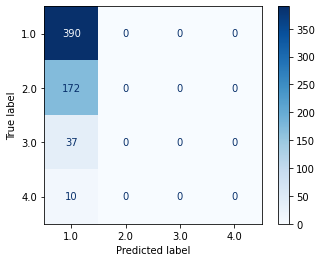

In [128]:
plot_confusion_matrix(modelo_SVM, X_train, Y_train, cmap='Blues', values_format='.0f')

Como pôde ser visualizado, utilizando dos melhores hiper-parâmetros para o modelo segundo o Grid Search, as métricas de desempenho permanecem praticamente inalteradas( apenas um leve aumento do f1-score), sugerindo que mesmo com os melhores parâmetros para esse modelo, ainda é perceptível um forte ruído na manipulação dos dados.

### 5.4.3-SVM com hiper-parâmetros(Randomized Search)

Buscando ainda analisar outros modelos de busca de hiper-parâmetros para servir de comparação com os resultados obtidos, foi o utilizado também o Randomized Search para a busca dos melhores hiper-parâmetros.

In [129]:
parametros_svm = {
    'kernel':['rbf'],#['linear','poly','rbf','sigmoid','precomputed'],
    'gamma':['scale','auto'],
    #'float':range(1,50),
    'degree':range(1,5)
}
randomized_search_svm = RandomizedSearchCV(estimator = SVC(),param_distributions=parametros_svm)
randomized_search_svm.fit(X_train,Y_train.squeeze())

modelRS_svm = randomized_search_svm.best_estimator_

y_predRS_svm = modelRS_svm.predict(X_test)

accuracy = accuracy_score(Y_test, y_predRS_svm)

print('SVM score: {}'.format(accuracy))
randomized_search_svm.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


SVM score: 0.6283524904214559


{'kernel': 'rbf', 'gamma': 'scale', 'degree': 1}

In [130]:
print(randomized_search_svm.best_score_)
print(randomized_search_svm.best_params_)

0.6387616854084813
{'kernel': 'rbf', 'gamma': 'scale', 'degree': 1}


In [131]:
svm_best= randomized_search_svm.best_estimator_
svm_best
print('Acc treino:',svm_best.score(X_train,Y_train))
print('Acc teste:',svm_best.score(X_test,Y_test.squeeze()))
print('Revocação:',recall_score(Y_test,y_predRS_svm,average=None))
print('Precisão:',precision_score(Y_test,y_predRS_svm,average=None))
print('F1_score:',precision_score(Y_test,y_predRS_svm,average=None))

Acc treino: 0.6403940886699507
Acc teste: 0.6283524904214559
Revocação: [1. 0. 0. 0.]
Precisão: [0.62835249 0.         0.         0.        ]
F1_score: [0.62835249 0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


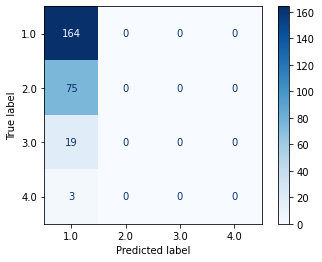

In [132]:
plot_confusion_matrix(modelRS_svm, X_test, Y_test, cmap='Blues', values_format='.0f');

Como pôde ser visualizado, utilizando os melhores hiper-parâmetros segundo o Randomized Search, o modelo ainda obteve resultados quase sem nenhuma variação em relação ao modelo original, indicando que ambas as buscas por hiper-parâmetros possuem um forte ruído na feature engineering dos dados que compromete o pleno funcionamento do modelo.

#6.0 - Análise dos resultados

Em um primeiro momento, foi decidido como parâmetro de avaliação de desempenho a acurácia dos modelos de aprendizagem de máquina, visto que essa métrica engloba todas possíveis variáveis de resultado, como os verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.

Dessa forma, com base nos resultados finais obtidos nos testes, conclui-se que o melhor método de aprendizagem de máquina para este projeto até o momento é a Árvore de decisão e o SVM,ambos empatados  com uma acurácia de 62% utilizando as métricas do Grid Search para o árvore e a ausência de métricas para o SVM .

Esse valor indica que , dentre todos os resultados dos testes de predições, o número de valores verdadeiros positivos e negativos para os modelos representam 62% do total, o que sugere uma revisão no tratamentos dos dados de modo a eliminar os falsos positivos e negativos, responsáveis por abaixar essa porcentagem e diminuir a precisão e recall do modelo, o que consequentemente abaixam a acurácia de modo geral.

Ademais, vale ressaltar que foram desconsiderados os resultados de acurácia dos modelos cujo resultado foi igual a 100% sem que esse valor fosse compatível com as outras métricas, indicando o possível vício de treinamento e fortes ruídos em uma ou mais features durante a limpeza e manipulação dos dados.

Em suma, será realizado uma revisão no processo de feature engeneering para buscar otimizar ainda mais o resultados para a entrega final, além de avaliar os pesos que cada coluna possui sobre a classificação de cada modelo de treinamento de modo a buscar e eliminar possíveis dados viciantes.
